In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/FrancescoZanella/RecSysChallenge2024.git

Cloning into 'RecSysChallenge2024'...
remote: Enumerating objects: 2864, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 2864 (delta 321), reused 453 (delta 312), pack-reused 2390
Receiving objects: 100% (2864/2864), 38.59 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (1816/1816), done.


In [2]:
%cd /kaggle/working/RecSysChallenge2024/src

/kaggle/working/RecSysChallenge2024/src


In [3]:
! pip install --upgrade polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 41.5 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.15
    Uninstalling polars-0.20.15:
      Successfully uninstalled polars-0.20.15


In [4]:
! pip install simsimd scikit-learn==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import (
    _preprocessing_history_trendiness_scores, 
    add_history_trendiness_scores_feature, 
    _preprocessing_mean_delay_features, 
    add_mean_delays_features, 
    _preprocessing_window_features, 
    add_window_features, 
    add_trendiness_feature_categories, 
    _preprocessing_article_endorsement_feature, 
    get_unique_categories,
    add_trendiness_feature
)

from catboost import CatBoostClassifier

2024-05-11 13:50:41.868802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 13:50:41.869063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 13:50:42.048606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Memory Utils

In [6]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.8685


In [7]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [8]:
articles = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/articles.parquet')

behaviors_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/train/history.parquet')

behaviors_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/behaviors.parquet')
history_val = pl.read_parquet('/kaggle/input/recommender-systems-challenge-2024/ebnerd_small/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 1.125


# Articles Preprocessing

In [9]:
articles = articles.with_columns(
    pl.col('image_ids').list.len().alias('num_images'),
    pl.col('title').str.split(by=' ').list.len().alias('title_len'),
    pl.col('subtitle').str.split(by=' ').list.len().alias('subtitle_len'),
    pl.col('body').str.split(by=' ').list.len().alias('body_len'),
    # very important for tf-idf, otherwise multiple tokens for topics with spaces are built
    pl.col('topics').list.eval(pl.element().str.split(by=' ').list.join('_')),
    pl.col('topics').list.len().alias('num_topics'),
    (pl.col('total_pageviews') / pl.col('total_inviews')).alias('total_pageviews/inviews')
)
articles = reduce_polars_df_memory_size(articles)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)

Memory usage of dataframe is 58.23 MB
Memory usage after optimization is: 58.00 MB
Decreased by 0.4%

RAM memory GB usage = 1.133


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null


In [10]:
unique_entities = articles.select('entity_groups').explode('entity_groups')['entity_groups'].unique().to_list()
unique_entities = [e for e in unique_entities if e is not None]
unique_entities

['PROD', 'MISC', 'LOC', 'ORG', 'EVENT', 'PER']

In [11]:
# in case of two category_str for the same category, one of the two is picked
unique_categories_df = articles.select(['category', 'category_str']).unique('category').drop_nulls('category')
unique_categories = {
    row['category']: row['category_str'] for row in unique_categories_df.iter_rows(named=True)
}
unique_categories

{2504: 'bibliotek',
 140: 'krimi',
 2975: 'penge',
 539: 'ferie',
 572: 'side9',
 414: 'underholdning',
 1505: 'vin',
 498: 'musik',
 2731: 'dagsorden',
 2737: 'podcast',
 457: 'forbrug',
 2341: 'plus',
 2889: 'auto',
 22: 'horoskoper',
 561: 'haandvaerkeren',
 806: 'om_ekstra_bladet',
 118: 'nyheder',
 2077: 'opinionen',
 2: 'incoming',
 529: 'biler',
 142: 'sport',
 731: 'services',
 512: 'nationen',
 68: 'video',
 565: 'sex_og_samliv'}

Mapping sentiment labels to -1, 0, 1 to save memory in the history dataframe.
Taking only article_default type and mapping it to 0/1 since after only this is needed (and it saves memory) for the history at the moment

In [12]:
articles = articles.with_columns(
    pl.when(pl.col('sentiment_label') == 'Negative').then(-1) \
        .otherwise(
            pl.when(pl.col('sentiment_label') == 'Positive').then(1).otherwise(0)
        ).cast(pl.Int8).alias('sentiment_label_int'),
    (pl.col('article_type') == 'article_default').cast(pl.UInt8).alias('is_article_default')
)

## Topics TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
articles = articles.with_columns(
    pl.Series(
        vectorizer.fit_transform(
            articles.with_columns(pl.col('topics').list.join(separator=' '))['topics'].to_list()
        ).toarray().astype(np.float32)
    ).alias('topics_idf')
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
articles.head(2)


RAM memory GB usage = 1.147


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32]
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]"


In [14]:
# without split + join with _ of the single topics this returns 94
len(vectorizer.get_feature_names_out())

79

## Topic Model

In [15]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

stopwords = nltk.corpus.stopwords.words('danish')
title_vectorizer = CountVectorizer(stop_words=stopwords)

titles_bow = title_vectorizer.fit_transform(articles['title'].to_list())

In [16]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

# parameters tuned on perplexity
N_COMPONENTS = 5
lda_model = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    doc_topic_prior=0.99,
    topic_word_prior=0.75,
    learning_method='online'
)
articles = articles.with_columns(
    pl.Series(lda_model.fit_transform(titles_bow).astype(np.float32)) \
        .list.to_array(5).alias('topic_model_embeddings')
)
articles.head(2)

CPU times: user 39 s, sys: 0 ns, total: 39 s
Wall time: 39 s


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embeddings
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],"array[f32, 5]"
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]","[0.143745, 0.280806, … 0.143695]"
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]","[0.148555, 0.112184, … 0.108768]"


In [17]:
topic_model_columns = [f'topic_model_embedding_{i}' for i in range(N_COMPONENTS)]

articles = articles.with_columns(
    pl.col('topic_model_embeddings').arr.to_struct(fields=lambda i: f'topic_model_embedding_{i}')
).with_columns([
    pl.col('topic_model_embeddings').struct.field(f'topic_model_embedding_{i}') for i in range(N_COMPONENTS)
]).drop('topic_model_embeddings')

articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews/inviews,sentiment_label_int,is_article_default,topics_idf,topic_model_embedding_0,topic_model_embedding_1,topic_model_embedding_2,topic_model_embedding_3,topic_model_embedding_4
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str,u32,u8,u8,u16,u32,f32,i8,u8,list[f32],f32,f32,f32,f32,f32
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig_kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative""",1,5,22,200,2,null,-1,1,"[0.0, 0.0, … 0.0]",0.143745,0.280806,0.143896,0.287859,0.143695
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film_og_tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive""",1,5,19,116,3,null,1,1,"[0.0, 0.0, … 0.536059]",0.148555,0.112184,0.522148,0.108345,0.108768


# History preprocessing

In [18]:
def add_topics_tf_idf_columns(df, topics_col, vectorizer):
    return df.with_columns(
        pl.Series(
            vectorizer.transform(
                df.with_columns(pl.col(topics_col).list.join(separator=' '))[topics_col].to_list()
            ).toarray().astype(np.float32)
        ).alias(f'{topics_col}_tf_idf')
    )

In [19]:
%%time

STRONG_THR = 0.8

history_train = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_train.iter_slices(1000), total=history_train.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_train = reduce_polars_df_memory_size(history_train)
history_train.head(2)

16it [00:17,  1.12s/it]                        



RAM memory GB usage = 1.291
Memory usage of dataframe is 39.39 MB
Memory usage after optimization is: 38.61 MB
Decreased by 2.0%
CPU times: user 21.5 s, sys: 2.05 s, total: 23.6 s
Wall time: 19.1 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,PRODPct,MISCPct,LOCPct,ORGPct,EVENTPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9739035, 9739065, … 9770533]","[2023-04-27 14:29:44, 2023-04-27 14:29:47, … 2023-05-17 17:36:24]","[118, 414, … 140]",143,3.0,1563.0,9623.0,42.5,100.0,0.230769,0.111888,0.657343,0.097902,0.083916,0.608392,0.06993,118,3,18,"[0.016041, 0.062928, … 0.178427]",0.237762,0.223776,0.804196,0.888112,0.202797,0.874126
12016,"[9738216, 9735383, … 9769622]","[2023-04-27 07:39:48, 2023-04-27 07:41:30, … 2023-05-17 23:56:30]","[140, 118, … 140]",264,156.0,1775.0,63672.0,100.0,100.0,0.257576,0.075758,0.666667,0.106061,0.034091,0.602273,0.07197,140,5,20,"[0.009749, 0.045896, … 0.075912]",0.318182,0.117424,0.776515,0.852273,0.087121,0.787879


In [20]:
history_train.shape

(15143, 27)

# Named entity collaborative filtering

In [21]:
user_id_mapping = history_train.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_mapping = articles.select(['ner_clusters']) \
    .explode('ner_clusters') \
    .rename({'ner_clusters': 'ner'}) \
    .with_columns(pl.col('ner').str.strip_chars_start('\" ').str.to_lowercase()) \
    .unique('ner').drop_nulls().filter(pl.col('ner').str.len_chars() > 0) \
    .sort('ner').with_row_index().rename({'index': 'ner_index'})

In [22]:
ner_interactions = history_train.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_train.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [23]:
%cd /kaggle/working
! git clone https://github.com/MaurizioFD/RecSys_Course_AT_PoliMi.git

/kaggle/working


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'RecSys_Course_AT_PoliMi'...
remote: Enumerating objects: 1519, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1519 (delta 223), reused 220 (delta 212), pack-reused 1264
Receiving objects: 100% (1519/1519), 50.33 MiB | 30.37 MiB/s, done.
Resolving deltas: 100% (909/909), done.


In [24]:
%cd /kaggle/working/RecSys_Course_AT_PoliMi

from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Evaluation.Evaluator import EvaluatorHoldout

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

/kaggle/working/RecSys_Course_AT_PoliMi
ItemKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 18909 (43.2%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 146.52 column/sec. Elapsed time 4.98 min
EvaluatorHoldout: Ignoring 31 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15112 (100.0%) in 49.38 sec. Users per second: 306


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.311971,0.312913,0.030088,0.214433,0.214676,0.469902,0.319612,0.054883,0.766609,0.953152,...,0.997953,0.76504,0.997953,0.002086,5.362616,0.952586,0.016842,0.419597,3.357942,0.009295


In [25]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 1 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 18909 (43.2%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.17 sec
EvaluatorHoldout: Processed 15112 (100.0%) in 26.06 sec. Users per second: 580


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.342628,0.345141,0.048661,0.261759,0.263204,0.670397,0.392258,0.085219,0.858655,1.275579,...,0.997953,0.856898,0.997953,0.001871,5.929536,0.95823,0.015104,0.463956,3.324192,0.009294


In [26]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_train.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_train.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).max().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 5min 7s, sys: 3min 29s, total: 8min 37s
Wall time: 2min 21s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
467872887,9778971,0.258346,0.15566,0.491131,0.201531,0.153908,0.753276
69838237,9672569,0.399106,0.620703,0.795401,0.411384,0.56518,0.944318
393588431,9363981,0.073997,0.2163,0.070395,0.002803,0.009098,0.005298
119015756,9777992,0.039844,0.02966,0.139723,0.067951,0.057289,0.344853
404967143,9773539,0.002342,0.010537,0.017659,0.0051,0.022948,0.042232


In [27]:
del URM_ner
del URM_ner_test
del ner_inview_scores
del ner_interactions
del ner_interactions_test
gc.collect()

0

# Creating Training Dataframe

In [28]:
def normalize_endorsement(articles_endorsement_raw):
    return articles_endorsement.sort(by='impression_time').with_columns(
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').sum().over('impression_time')
        ).alias('normalized_endorsement_10h'),
        (
            pl.col('endorsement_10h') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_10h_diff_rolling'),
        (
            pl.col('endorsement_10h').rolling_mean(5, min_periods=1).over('article') - 
            pl.col('endorsement_10h').rolling_mean(10, min_periods=1).over('article')
        ).alias('endorsement_macd'),
        (
            pl.col('endorsement_10h') / 
            pl.col('endorsement_10h').quantile(0.8).over('impression_time')
        ).alias('endorsement_quantile_norm_10h')
    ).with_columns(
        (
            pl.col('normalized_endorsement_10h') / 
            pl.col('normalized_endorsement_10h').rolling_max(10, min_periods=1).over('impression_time')
        ).alias('normalized_endorsement_10h_rolling_max_ratio'),
    )
    

def add_article_endorsement_feature(df_features, normalized_endorsement):
    # old return df_features.join(other=articles_endorsement, on=["article", "impression_time"], how="left")
    normalized_endorsement = normalized_endorsement.with_columns(pl.col('article').cast(pl.Int32))
    return df_features.with_columns(pl.col('impression_time').dt.round('1m').alias('rounded_impression_time'))\
                         .join(normalized_endorsement.rename({'impression_time' : 'rounded_impression_time'}), on=['article','rounded_impression_time'], how='left')\
                         .drop('rounded_impression_time')

In [29]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_train, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_train)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_train, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_train, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

topics = articles.select("topics").explode("topics").unique()
topics = [topic for topic in topics["topics"] if topic is not None]

# dropping duplicates that can occur because of sampling strategy
train_ds = behaviors_train.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 'total_pageviews/inviews']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours'),
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

train_ds = reduce_polars_df_memory_size(train_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head()

16it [00:41,  2.61s/it]
2427it [00:08, 302.38it/s]
16it [00:02,  6.92it/s]                        
16it [00:02,  5.89it/s]                        
100%|██████████| 506/506 [00:04<00:00, 107.38it/s]



RAM memory GB usage = 2.675
Memory usage of dataframe is 816.08 MB
Memory usage after optimization is: 497.97 MB
Decreased by 39.0%

RAM memory GB usage = 2.365
CPU times: user 15min 6s, sys: 54.3 s, total: 16min
Wall time: 4min 39s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,session_id,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,published_time,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_MISC_Present,Entity_LOC_Present,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,u32,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,datetime[μs],i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,bool,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32
88595535,9776438,2121561,2023-05-22 18:39:07,0,3,164.0,100.0,false,2,null,false,452528,null,3,6,12,1,18,0.5,0.25,0.010969,false,2023-05-22 18:21:42,118,0.833,"""Neutral""",1,7,18,221,1,116521,419194,8.177146e6,0.277964,0,0,false,false,true,true,false,true,0.393139,0.308334,0.622387,0.204307,0.226883,0.496908,213.896454,35.894962,0.19882,6.522742,15.86921,384.632141,415,380,93,0,0,1,1,0,191,5,103,187,0.004828,59.900002,32.700001,0.120723,0.047498
74801232,9755712,2569699,2023-05-20 09:24:49,0,2,35.0,100.0,false,2,null,false,1183012,null,41,108,200,6,9,0.37963,0.205,0.213861,true,2023-05-20 04:59:45,414,0.7513,"""Neutral""",8,5,9,489,3,34540,792850,1.95534e6,0.043564,0,4,false,false,true,true,false,false,0.041426,0.221786,0.197962,0.050935,0.35354,0.329809,187.631577,305.11261,3.595059,88.525108,4.484765,110.174515,217,157,12,67,1,0,0,0,18,68,53,2995,0.036105,31.6,16.799999,1.358893,1.0
410296696,9773278,2073616,2023-05-20 15:40:51,0,2,10.0,null,false,2,null,false,207680,null,143,406,666,6,15,0.352217,0.214715,0.80396,false,2023-05-20 13:53:40,142,0.9278,"""Positive""",10,9,19,531,4,137663,634085,1.4717939e7,0.217105,0,1,false,true,true,false,true,true,1.0,0.355826,1.0,0.733247,0.326833,0.986488,269.024384,385.301208,4.29419,105.5606,0.109756,3.890244,36,36,21,6,0,1,0,0,9,46,107,1056,0.010987,70.5,37.5,0.596947,0.34657
491222213,9772045,2203615,2023-05-19 06:35:51,0,2,27.0,100.0,false,2,null,false,1800018,null,30,91,150,5,6,0.32967,0.2,0.147967,false,2023-05-19 05:15:59,140,0.9968,"""Negative""",1,5,10,130,3,121706,507540,5.147786e6,0.239796,0,1,false,false,true,true,false,true,0.091943,0.25744,0.269673,0.183565,0.513982,0.524565,224.733337,143.783981,6.257736,152.479141,32.933334,795.200012,43,2,0,13,1,0,0,0,2,10,62,1158,0.012303,79.099998,42.700001,0.626284,0.283407
352891692,9777582,2020528,2023-05-23 20:01:14,0,2,16.0,null,false,2,null,false,461264,null,52,124,207,2,20,0.419355,0.251208,0.210169,false,2023-05-23 19:31:20,414,0.8814,"""Neutral""",1,6,20,303,7,106005,406652,7.412317e6,0.260677,0,0,true,false,true,true,false,true,0.278178,0.199386,0.214764,0.09442,0.08558,0.165119,243.810532,171.687378,29.845846,719.534729,19.484211,473.168427,36,27,11,32,0,0,1,0,5,8,42,326,0.004157,52.400002,27.200001,0.214474,0.137148


In [30]:
train_ds.shape

(2585747, 73)

## Session Features

In [31]:
# behaviors_train.select(['session_id', 'impression_time', 'article_ids_clicked']) \
#     .group_by('session_id').map_groups(
#         lambda group: group.explode('article_ids_clicked').sort('impression_time') \
#             .select(
#                 pl.col('session_id').first(),
#                 pl.col('article_ids_clicked').first().alias('article_id'),
#                 (pl.col('impression_time').last() - pl.col('impression_time').first()).dt.total_minutes().alias('induced_session_len'),
#                 (pl.col('impression_time').count() - 1).alias('num_clicked_articles_following')
#             )
#     ).group_by('article_id').agg(
#         pl.col('num_clicked_articles_following').mean().alias('mean_num_clicked_articles_following'),
#         pl.col('induced_session_len').mean().alias('mean_induced_session_len'),
#     )

In [32]:
%%time

last_history_df = history_train.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_train.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration', 
              'all_seen_articles', 'mean_prev_sessions_duration'])
    
gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
last_session_time_df.head(2)


RAM memory GB usage = 2.347
CPU times: user 2.11 s, sys: 124 ms, total: 2.23 s
Wall time: 1.66 s


session_id,last_session_time,last_session_duration,all_seen_articles,mean_prev_sessions_duration
u32,datetime[μs],i64,list[i32],f64
734220,2023-05-17 12:32:34,0,[9769704],0.0
793522,2023-05-18 05:29:42,0,[9770799],0.0


In [33]:
train_ds = train_ds.join(last_session_time_df, on='session_id', how='left').with_columns(
    (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
    ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
    pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time'])

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)


RAM memory GB usage = 2.702


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,…,Entity_ORG_Present,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article
u32,i32,u32,datetime[μs],i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i64,f64,i64,bool,bool
88595535,9776438,2121561,2023-05-22 18:39:07,0,3,164.0,100.0,false,2,null,false,null,3,6,12,1,18,0.5,0.25,0.010969,false,118,0.833,"""Neutral""",1,7,18,221,1,116521,419194,8.177146e6,0.277964,0,0,false,…,true,false,true,0.393139,0.308334,0.622387,0.204307,0.226883,0.496908,213.896454,35.894962,0.19882,6.522742,15.86921,384.632141,415,380,93,0,0,1,1,0,191,5,103,187,0.004828,59.900002,32.700001,0.120723,0.047498,6,3.652174,32,false,false
74801232,9755712,2569699,2023-05-20 09:24:49,0,2,35.0,100.0,false,2,null,false,null,41,108,200,6,9,0.37963,0.205,0.213861,true,414,0.7513,"""Neutral""",8,5,9,489,3,34540,792850,1.95534e6,0.043564,0,4,false,…,true,false,false,0.041426,0.221786,0.197962,0.050935,0.35354,0.329809,187.631577,305.11261,3.595059,88.525108,4.484765,110.174515,217,157,12,67,1,0,0,0,18,68,53,2995,0.036105,31.6,16.799999,1.358893,1.0,0,0.62963,-2,true,false


In [34]:
train_ds.select(pl.col('is_new_article').sum() / train_ds.shape[0], pl.col('is_already_seen_article').sum() / train_ds.shape[0])

is_new_article,is_already_seen_article
f64,f64
0.559477,0.024018


In [35]:
del last_history_df
del last_session_time_df
gc.collect()

0

## Popularities

In [36]:
%%time

articles_date_popularity = articles.select(['published_time', 'article_id']) \
    .group_by(pl.col('published_time').dt.date().alias('published_date')) \
    .agg(pl.col('article_id').count().alias('daily_articles')) \

published_category_popularity = articles.select(['published_time', 'article_id', 'category']) \
    .group_by([pl.col('published_time').dt.date().alias('published_date'), 'category']) \
    .agg(pl.col('article_id').count().alias('category_daily_articles')) \
    .join(articles_date_popularity, on='published_date', how='left') \
    .with_columns((pl.col('category_daily_articles') / pl.col('daily_articles')).alias('category_daily_pct')) \
    .drop(['category_daily_articles', 'daily_articles'])

train_ds = train_ds.join(published_category_popularity, how='left', right_on=['published_date', 'category'],
                         left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))
train_ds = reduce_polars_df_memory_size(train_ds)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

Memory usage of dataframe is 538.35 MB
Memory usage after optimization is: 486.25 MB
Decreased by 9.7%

RAM memory GB usage = 2.633
CPU times: user 1.89 s, sys: 505 ms, total: 2.4 s
Wall time: 2.15 s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,…,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
88595535,9776438,2121561,2023-05-21,0,3,164.0,100.0,false,2,null,false,null,3,6,12,1,18,0.5,0.25,0.010969,false,118,0.833,"""Neutral""",1,7,18,221,1,116521,419194,8.177146e6,0.277964,0,0,false,…,false,true,0.393139,0.308334,0.622387,0.204307,0.226883,0.496908,213.896454,35.894962,0.19882,6.522742,15.86921,384.632141,415,380,93,0,0,1,1,0,191,5,103,187,0.004828,59.900002,32.700001,0.120723,0.047498,6,3.652174,32,false,false,0.342105
74801232,9755712,2569699,2023-05-19,0,2,35.0,100.0,false,2,null,false,null,41,108,200,6,9,0.37963,0.205,0.213861,true,414,0.7513,"""Neutral""",8,5,9,489,3,34540,792850,1.95534e6,0.043564,0,4,false,…,false,false,0.041426,0.221786,0.197962,0.050935,0.35354,0.329809,187.631577,305.11261,3.595059,88.525108,4.484765,110.174515,217,157,12,67,1,0,0,0,18,68,53,2995,0.036105,31.6,16.799999,1.358893,1.0,0,0.62963,-2,true,false,0.146341


# Adding history features

In [37]:
def list_pct_matches_with_col(a, b) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with another column.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise((pl.col(a).list.len() - (pl.col(a).list.set_difference(pl.col(b))).list.len()) / pl.col(a).list.len())


def list_pct_matches_with_constant(a, value) -> pl.Expr:
    '''
    Returns an expression to count the percentage of matching element in a list with a constant value.
    The polars function count_matches cannot be used since it wants only a single element, 
    variable element from row to row.
    '''
    return pl.when(pl.col(a).list.len() == 0).then(0.0) \
        .otherwise(pl.col(a).list.count_matches(value) / pl.col(a).list.len())


def cosine_similarity(x, y):
    x = np.array(x)
    y = np.array(y)
    normalization = np.linalg.norm(x, 2) * np.linalg.norm(y, 2)
    return np.dot(x, y) / normalization if normalization > 0 else 0


prev_train_columns = [c for c in train_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

train_ds = pl.concat(
    rows.join(history_train.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
#         ).sort(by='impression_time_fixed').group_by(['impression_id', 'article']).agg(
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
#             pl.col("JS").tail(5).mean().alias("mean_JS_tail_5"),
#             pl.col("JS").tail(10).mean().alias("mean_JS_tail_10"),
#             pl.col("JS").tail(25).mean().alias("mean_JS_tail_25"),
#             pl.col("JS").quantile(0.3).alias("quantile_JS_0.3"),
#             pl.col("JS").quantile(0.7).alias("quantile_JS_0.7"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
#             pl.col("topic_model_cosine").tail(5).mean().alias("mean_topic_model_cosine_tail_5"),
#             pl.col("topic_model_cosine").tail(10).mean().alias("mean_topic_model_cosine_tail_10"),
#             pl.col("topic_model_cosine").tail(25).mean().alias("mean_topic_model_cosine_tail_25"),
#             pl.col("topic_model_cosine").quantile(0.3).alias("quantile_topic_model_cosine_0.3"),
#             pl.col("topic_model_cosine").quantile(0.7).alias("quantile_topic_model_cosine_0.7"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_train.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(train_ds.iter_slices(10000), total=train_ds.shape[0] // 10000)
)
train_ds = reduce_polars_df_memory_size(train_ds)

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
train_ds.head(2)

259it [40:10,  9.31s/it]


Memory usage of dataframe is 1537.68 MB
Memory usage after optimization is: 1155.45 MB
Decreased by 24.9%

RAM memory GB usage = 5.135


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,PRODPct,MISCPct,LOCPct,ORGPct,EVENTPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_bibliotek_Pct,Category_krimi_Pct,Category_penge_Pct,Category_ferie_Pct,Category_side9_Pct,Category_underholdning_Pct,Category_vin_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_podcast_Pct,Category_forbrug_Pct,Category_plus_Pct,Category_auto_Pct,Category_horoskoper_Pct,Category_haandvaerkeren_Pct,Category_om_ekstra_bladet_Pct,Category_nyheder_Pct,Category_opinionen_Pct,Category_incoming_Pct,Category_biler_Pct,Category_sport_Pct,Category_services_Pct,Category_nationen_Pct,Category_video_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
399446271,9755712,306558,0,1,33.0,100.0,false,2,null,false,null,41,108,200,6,9,0.37963,0.205,0.213861,true,414,0.7513,"""Neutral""",8,5,9,489,3,34540,792850,1.95534e6,0.043564,0,4,false,false,…,3,20,0.414634,0.073171,0.756098,0.987805,0.182927,0.865854,0.167906,false,6,0.939024,0.0,0.353659,0.0,0.0,0.0,0.341463,0.0,0.036585,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,0.219512,0.0,0.0,0.0,0.02439,0.0,0.0,0.0,0.0
156724578,9771083,1047946,0,2,30.0,null,false,2,null,false,null,149,453,840,4,8,0.328918,0.177381,0.879612,false,142,0.9808,"""Negative""",2,6,16,223,5,33581,281258,2.330956e6,0.119396,0,1,false,false,…,6,17,0.203209,0.139037,0.721925,0.946524,0.256684,0.834225,0.750844,true,11,0.946524,0.0,0.203209,0.032086,0.005348,0.0,0.106952,0.0,0.010695,0.005348,0.0,0.005348,0.0,0.005348,0.0,0.0,0.0,0.219251,0.0,0.0,0.0,0.40107,0.0,0.005348,0.0,0.0


In [38]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]

train_ds = train_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
)

# Training

In [39]:
# subsample dataset

behaviors_subsample = behaviors_train.select(['impression_id','user_id','article_ids_inview','article_ids_clicked']) \
    .pipe(
        sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
    ).explode('article_ids_inview').drop('article_ids_clicked').rename({'article_ids_inview' : 'article'}) \
    .with_columns(pl.col('user_id').cast(pl.UInt32), pl.col('article').cast(pl.Int32)) \
    .select(['impression_id', 'user_id', 'article'])

train_ds = behaviors_subsample.join(train_ds, on=['impression_id','user_id','article'], how='left')
train_ds.head()

impression_id,user_id,article,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_MISC_Present,…,std_impression_total_inviews,std_impression_trendiness_score_category,std_impression_std_JS,std_impression_trendiness_score_5d,skew_impression_trendiness_score_3d,skew_impression_endorsement_10h,skew_impression_total_pageviews/inviews,skew_impression_mean_JS,skew_impression_mean_topic_model_cosine,skew_impression_topics_cosine,skew_impression_article_delay_hours,skew_impression_total_pageviews,skew_impression_total_inviews,skew_impression_trendiness_score_category,skew_impression_std_JS,skew_impression_trendiness_score_5d,kurtosis_impression_trendiness_score_3d,kurtosis_impression_endorsement_10h,kurtosis_impression_total_pageviews/inviews,kurtosis_impression_mean_JS,kurtosis_impression_mean_topic_model_cosine,kurtosis_impression_topics_cosine,kurtosis_impression_article_delay_hours,kurtosis_impression_total_pageviews,kurtosis_impression_total_inviews,kurtosis_impression_trendiness_score_category,kurtosis_impression_std_JS,kurtosis_impression_trendiness_score_5d,mean_JS_l_inf_user,std_JS_l_inf_user,mean_topic_model_cosine_l_inf_user,topics_cosine_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,mean_topic_model_cosine_l_inf_article,topics_cosine_l_inf_article
u32,u32,i32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,…,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32
149474,139836,9778728,0,2,13.0,null,false,2,null,false,null,150,521,836,3,7,0.287908,0.179426,0.880068,false,142,0.9654,"""Negative""",1,5,18,251,7,22415,220247,1.004828e6,0.101772,0,0,true,false,…,121953.454466,47.60007,0.049983,245.939356,0.524737,-0.40504,0.054168,0.419334,-0.192887,0.534873,-0.707107,-0.034176,-0.440411,-0.994641,-0.102426,0.486288,-1.092662,-1.534209,-1.082417,-0.674712,-0.930721,-0.141565,-1.5,-1.31432,-1.434347,-0.69549,-1.613803,-1.15085,0.447581,0.403328,0.887154,0.36119,0.0,0.233531,0.335164,0.820744,0.301919
149474,139836,9778669,0,2,13.0,null,false,2,null,false,null,85,199,313,3,7,0.427136,0.271565,0.336149,false,118,0.9481,"""Negative""",1,5,11,150,4,74491,373488,4.365609e6,0.199447,0,1,true,false,…,121953.454466,47.60007,0.049983,245.939356,0.524737,-0.40504,0.054168,0.419334,-0.192887,0.534873,-0.707107,-0.034176,-0.440411,-0.994641,-0.102426,0.486288,-1.092662,-1.534209,-1.082417,-0.674712,-0.930721,-0.141565,-1.5,-1.31432,-1.434347,-0.69549,-1.613803,-1.15085,0.501163,0.632488,0.753515,0.437299,0.043478,0.266627,0.511387,0.829251,0.319083
149474,139836,9778657,1,2,13.0,null,false,2,null,false,null,45,117,183,3,7,0.384615,0.245902,0.197635,false,118,0.8347,"""Neutral""",2,6,31,336,3,108389,478098,7.606737e6,0.226709,0,1,false,true,…,121953.454466,47.60007,0.049983,245.939356,0.524737,-0.40504,0.054168,0.419334,-0.192887,0.534873,-0.707107,-0.034176,-0.440411,-0.994641,-0.102426,0.486288,-1.092662,-1.534209,-1.082417,-0.674712,-0.930721,-0.141565,-1.5,-1.31432,-1.434347,-0.69549,-1.613803,-1.15085,0.78901,0.718014,0.816663,0.801144,0.066667,0.350947,0.730242,0.873616,0.604487
150528,143471,9778682,0,2,25.0,null,false,2,null,false,null,69,206,334,3,7,0.334951,0.206587,0.347973,false,498,0.9546,"""Negative""",1,5,20,267,3,143520,455723,9.298546e6,0.314928,0,1,true,false,…,100872.979425,48.701757,0.058219,261.444598,0.721425,0.244098,-0.150585,-1.677991,-0.111166,-1.024629,0.223607,-0.261278,-0.

In [40]:
train_ds = train_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [41]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 5.6


In [42]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, rsm=0.7, subsample=0.5)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.169254
0:	learn: 0.6502437	total: 970ms	remaining: 16m 9s
25:	learn: 0.5269680	total: 25.7s	remaining: 16m 1s
50:	learn: 0.5089971	total: 51.1s	remaining: 15m 50s
75:	learn: 0.4989278	total: 1m 14s	remaining: 15m 4s
100:	learn: 0.4912227	total: 1m 38s	remaining: 14m 34s
125:	learn: 0.4853723	total: 2m 2s	remaining: 14m 10s
150:	learn: 0.4805619	total: 2m 27s	remaining: 13m 46s
175:	learn: 0.4760807	total: 2m 50s	remaining: 13m 16s
200:	learn: 0.4723032	total: 3m 13s	remaining: 12m 48s
225:	learn: 0.4688084	total: 3m 36s	remaining: 12m 20s
250:	learn: 0.4657956	total: 3m 59s	remaining: 11m 55s
275:	learn: 0.4627489	total: 4m 23s	remaining: 11m 31s
300:	learn: 0.4602084	total: 4m 47s	remaining: 11m 8s
325:	learn: 0.4578762	total: 5m 11s	remaining: 10m 43s
350:	learn: 0.4555439	total: 5m 34s	remaining: 10m 18s
375:	learn: 0.4535750	total: 5m 57s	remaining: 9m 53s
400:	learn: 0.4514776	total: 6m 21s	remaining: 9m 29s
425:	learn: 0.4494523	total: 6m 44s	remaining: 9m 

In [43]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 14.2 s, sys: 260 ms, total: 14.5 s
Wall time: 14.3 s


Text(0.5, 1.0, 'Catboost Feature Importances')

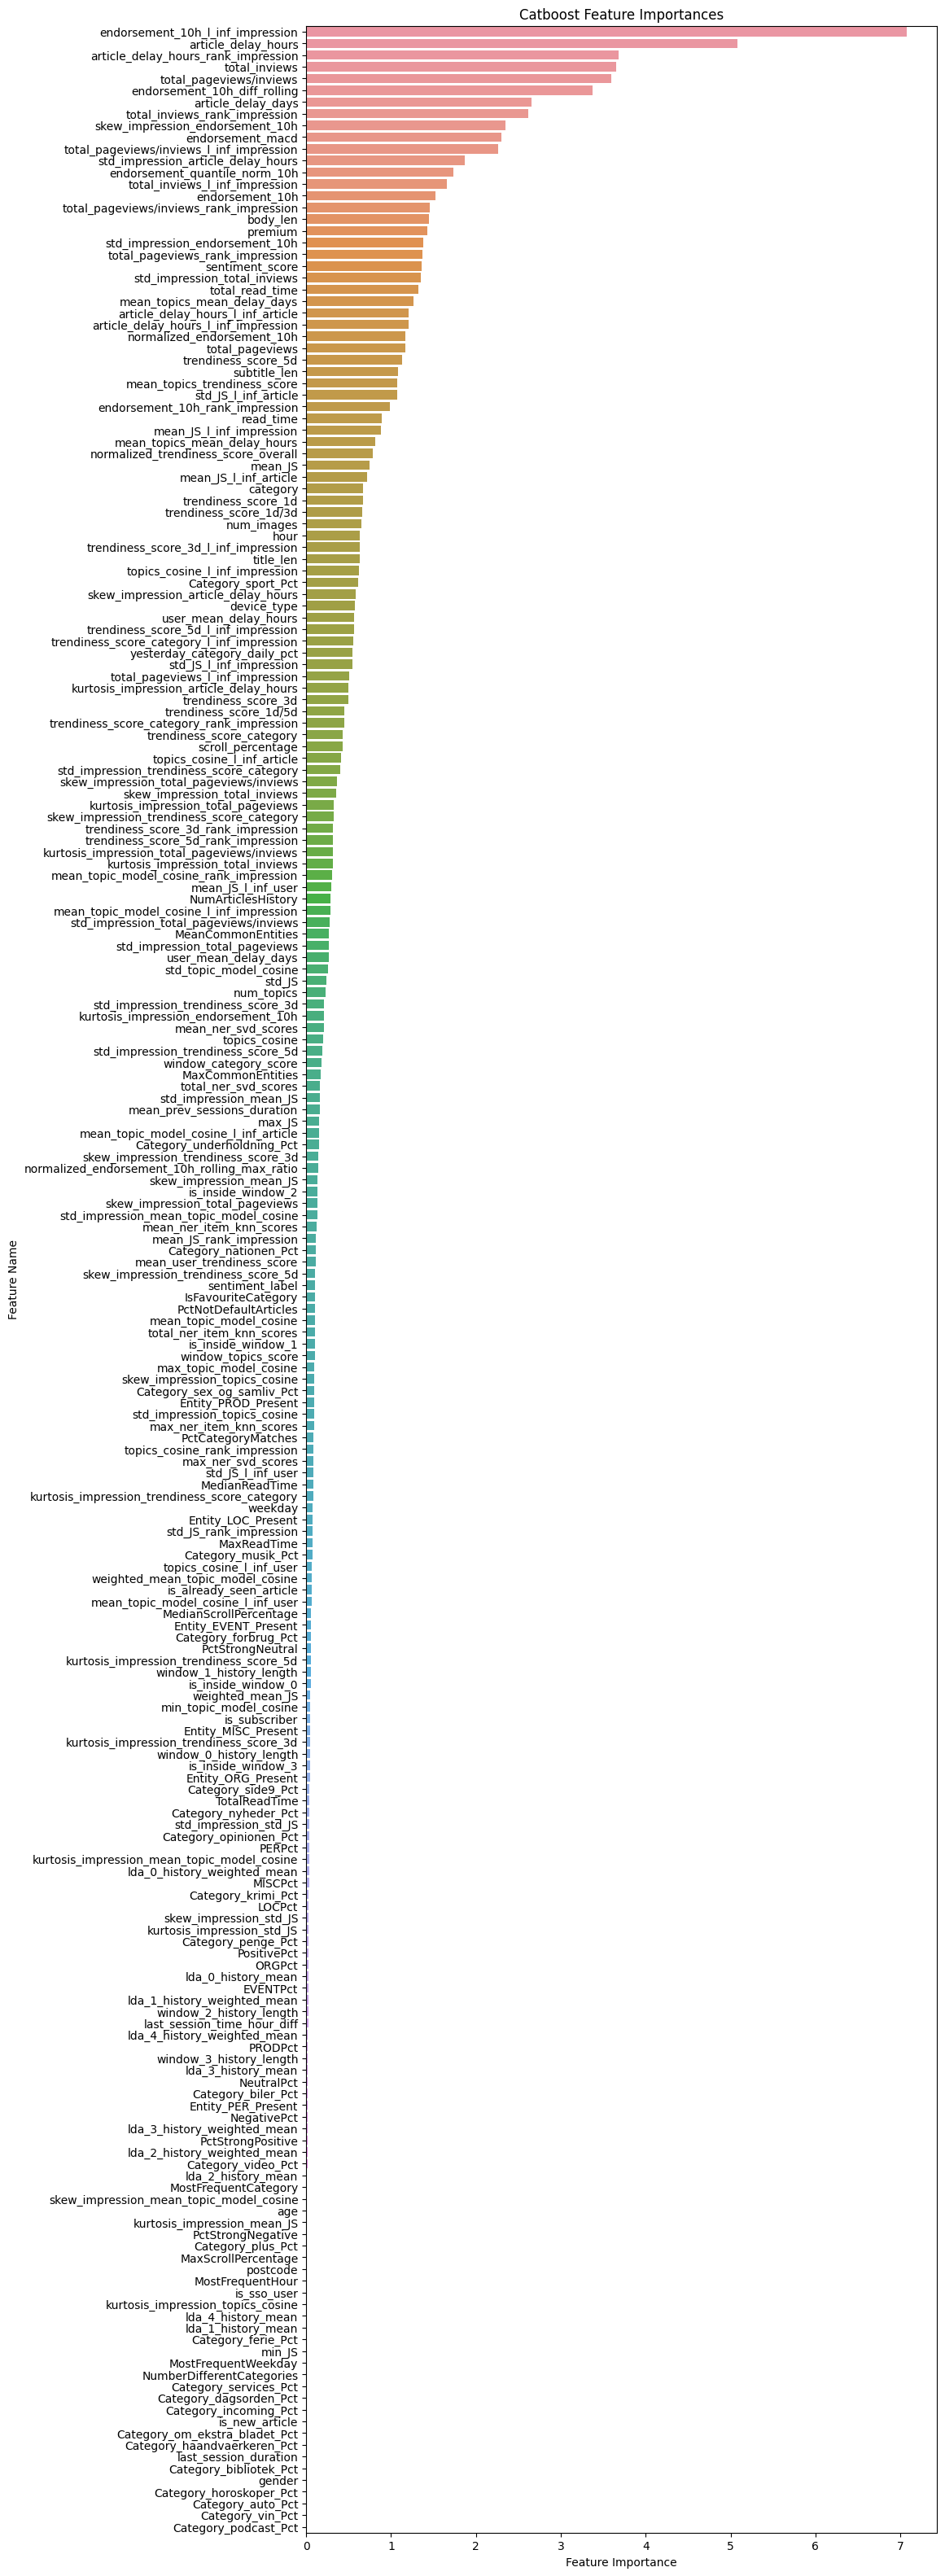

In [44]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 40))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [45]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 6.468


# Model Evaluation

In [46]:
user_id_mapping = history_val.sort('user_id').with_row_index() \
    .select(['index', 'user_id']).rename({'index': 'user_index'})

ner_interactions = history_val.select(['user_id', 'article_id_fixed']).explode('article_id_fixed') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_id_fixed', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_id_fixed']) \
    .unique(['user_index', 'ner_index'])

URM_ner = sps.csr_matrix((np.ones(ner_interactions.shape[0]),
                          (ner_interactions['user_index'].to_numpy(), ner_interactions['ner_index'].to_numpy())),
                         shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

ner_interactions_test = behaviors_val.select(['user_id', 'article_ids_clicked']).explode('article_ids_clicked') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_clicked', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_clicked']) \
    .unique(['user_index', 'ner_index'])

URM_ner_test = sps.csr_matrix((np.ones(ner_interactions_test.shape[0]),
                               (ner_interactions_test['user_index'].to_numpy(), ner_interactions_test['ner_index'].to_numpy())),
                              shape=(user_id_mapping.shape[0], ner_mapping.shape[0]))

In [47]:
item_knn = ItemKNNCFRecommender(URM_ner)
item_knn.fit(topK=100, similarity='jaccard')

evaluator = EvaluatorHoldout(URM_ner_test, cutoff_list=[10], exclude_seen=False)
result_df, _ = evaluator.evaluateRecommender(item_knn)
result_df

ItemKNNCFRecommender: URM Detected 3 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 19035 (43.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 43774 (100.0%), 156.79 column/sec. Elapsed time 4.65 min
EvaluatorHoldout: Ignoring 32 ( 0.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 15310 (100.0%) in 48.39 sec. Users per second: 316


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.338445,0.339461,0.033197,0.241643,0.241977,0.493913,0.346767,0.060464,0.784651,1.033204,...,0.997914,0.783014,0.997914,0.002568,5.473111,0.953841,0.020621,0.428217,3.43338,0.010093


In [48]:
pure_svd = PureSVDRecommender(URM_ner)
pure_svd.fit(num_factors=20)

result_df, _ = evaluator.evaluateRecommender(pure_svd)
result_df

PureSVDRecommender: URM Detected 3 ( 0.0%) users with no interactions.
PureSVDRecommender: URM Detected 19035 (43.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 4.77 sec
EvaluatorHoldout: Processed 15310 (100.0%) in 26.69 sec. Users per second: 574


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.365382,0.368539,0.050795,0.283615,0.285707,0.695447,0.415659,0.089191,0.876486,1.342637,...,0.997914,0.874658,0.997914,0.001527,5.728555,0.954883,0.012263,0.448203,3.536612,0.010003


In [49]:
%%time

def get_inview_scores(user_ners_df, recommender, f_name):
    user_index = user_ners_df['user_index'].to_list()[0]
    ners = user_ners_df['ner_index'].to_numpy()
    scores = recommender._compute_item_score([user_index], ners)[0, ners]
    return user_ners_df.with_columns(
        pl.Series(scores).alias(f_name)
    )

ner_inview_scores = behaviors_val.select(['user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(articles.select(['article_id', 'ner_clusters']), left_on='article_ids_inview', right_on='article_id', how='left') \
    .explode('ner_clusters').unique(['user_id', 'ner_clusters']) \
    .with_columns(pl.col('ner_clusters').str.strip_chars_start('\" ').str.to_lowercase()) \
    .join(user_id_mapping, on='user_id', how='left') \
    .join(ner_mapping, left_on='ner_clusters', right_on='ner') \
    .select(['user_index', 'ner_index', 'user_id', 'article_ids_inview']) \
    .unique(['user_index', 'ner_index']) \
    .sort(['user_index', 'ner_index']).group_by('user_index').map_groups(
        lambda user_df: user_df.pipe(get_inview_scores, recommender=pure_svd, f_name='pure_svd_scores') \
            .pipe(get_inview_scores, recommender=item_knn, f_name='item_knn_scores')
    )

behaviors_ner_scores = behaviors_val.select(['impression_id', 'user_id', 'article_ids_inview']).explode('article_ids_inview') \
    .join(ner_inview_scores, on=['user_id', 'article_ids_inview'], how='left') \
    .with_columns(pl.col(['pure_svd_scores', 'item_knn_scores']).fill_null(0)) \
    .group_by(['impression_id', 'article_ids_inview']).agg(
        pl.col('pure_svd_scores').sum().alias('total_ner_svd_scores'),
        pl.col('pure_svd_scores').mean().alias('mean_ner_svd_scores'),
        pl.col('pure_svd_scores').max().alias('max_ner_svd_scores'),
        pl.col('item_knn_scores').sum().alias('total_ner_item_knn_scores'),
        pl.col('item_knn_scores').mean().alias('mean_ner_item_knn_scores'),
        pl.col('item_knn_scores').max().alias('max_ner_item_knn_scores'),
    ).with_columns(
        pl.col(['total_ner_svd_scores', 'mean_ner_svd_scores', 
                'total_ner_item_knn_scores', 'mean_ner_item_knn_scores',
                'max_ner_svd_scores', 'max_ner_item_knn_scores']).sum().over('impression_id').name.suffix('_max')
    ).with_columns(
        # l1 normalization
        pl.col('total_ner_svd_scores').truediv(pl.col('total_ner_svd_scores_max')),
        pl.col('mean_ner_svd_scores').truediv(pl.col('mean_ner_svd_scores_max')),
        pl.col('max_ner_svd_scores').truediv(pl.col('max_ner_svd_scores_max')),
        pl.col('total_ner_item_knn_scores').truediv(pl.col('total_ner_item_knn_scores_max')),
        pl.col('mean_ner_item_knn_scores').truediv(pl.col('mean_ner_item_knn_scores_max')),
        pl.col('max_ner_item_knn_scores').truediv(pl.col('max_ner_item_knn_scores_max')),
    ).drop(['total_ner_svd_scores_max', 'mean_ner_svd_scores_max', 
            'max_ner_svd_scores_max', 'total_ner_item_knn_scores_max',
            'mean_ner_item_knn_scores_max', 'max_ner_item_knn_scores_max']) \
    .rename({'article_ids_inview': 'article'})
behaviors_ner_scores.head(5)

CPU times: user 5min 2s, sys: 3min 23s, total: 8min 25s
Wall time: 2min 19s


impression_id,article,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores
u32,i32,f32,f32,f32,f32,f32,f32
227474670,9788516,0.108805,0.104799,0.168285,0.138912,0.14876,0.194692
309302063,9773779,0.437777,0.03417,0.12727,0.467472,0.03851,0.130956
27374828,9788462,0.223403,0.243125,0.295233,0.24609,0.270305,0.258872
242117190,9777321,0.0,0.0,0.0,0.0,0.0,0.0
266750917,9784702,0.017171,0.012626,0.02108,0.012866,0.009759,0.016667


In [50]:
%%time

STRONG_THR = 0.8

history_val = pl.concat(
    rows.with_columns(pl.col('article_id_fixed').list.len().alias('NumArticlesHistory')) \
        .explode(['article_id_fixed', 'impression_time_fixed', 'read_time_fixed', 'scroll_percentage_fixed']) \
        .sort(by=['user_id', 'impression_time_fixed']) \
        .with_columns(
            pl.col('impression_time_fixed').dt.weekday().alias('weekday'),
            pl.col('impression_time_fixed').dt.hour().alias('hour'),
        ).join(articles.select(['article_id', 'category', 'is_article_default', 'sentiment_label_int', 
                                'sentiment_score', 'entity_groups', 'topics']), 
               left_on='article_id_fixed', right_on='article_id', how='left') \
        .with_columns(
            (pl.col('sentiment_label_int') == 0).alias('is_neutral'),
            (pl.col('sentiment_label_int') == 1).alias('is_positive'),
            (pl.col('sentiment_label_int') == -1).alias('is_negative'),
            ((pl.col('sentiment_label_int') == 0) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_neutral'),
            ((pl.col('sentiment_label_int') == 1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_positive'),
            ((pl.col('sentiment_label_int') == -1) & (pl.col('sentiment_score') > STRONG_THR)).alias('strong_negative'),
            pl.col('entity_groups').list.unique(),
        ).group_by('user_id').agg(
            pl.col('article_id_fixed'),
            pl.col('impression_time_fixed'),
            pl.col('category'),
            pl.col('NumArticlesHistory').first(),
            pl.col('read_time_fixed').median().alias('MedianReadTime'),
            pl.col('read_time_fixed').max().alias('MaxReadTime'),
            pl.col('read_time_fixed').sum().alias('TotalReadTime'),
            pl.col('scroll_percentage_fixed').median().alias('MedianScrollPercentage'),
            pl.col('scroll_percentage_fixed').max().alias('MaxScrollPercentage'),
            (pl.col('is_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('NeutralPct'),
            (pl.col('is_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PositivePct'),
            (pl.col('is_negative').sum() / pl.col('NumArticlesHistory').first()).alias('NegativePct'),
            (pl.col('strong_neutral').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNeutral'),
            (pl.col('strong_positive').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongPositive'),
            (pl.col('strong_negative').sum() / pl.col('NumArticlesHistory').first()).alias('PctStrongNegative'),
            (1 - (pl.col('is_article_default').sum() / pl.col('NumArticlesHistory').first())).alias('PctNotDefaultArticles'),
            pl.col('category').mode().alias('MostFrequentCategory'),
            pl.col('weekday').mode().alias('MostFrequentWeekday'),
            pl.col('hour').mode().alias('MostFrequentHour'),
            pl.col('entity_groups').flatten(),
            pl.col('topics').flatten().alias('topics_flatten')
        ).pipe(add_topics_tf_idf_columns, topics_col='topics_flatten', vectorizer=vectorizer) \
        .drop('topics_flatten').with_columns(
            pl.col('MostFrequentCategory').list.first(),
            pl.col('MostFrequentWeekday').list.first(),
            pl.col('MostFrequentHour').list.first(),
        ).with_columns(
            (pl.col('entity_groups').list.count_matches(entity) / pl.col('NumArticlesHistory')).alias(f'{entity}Pct')
            for entity in unique_entities
        ).drop('entity_groups')
    for rows in tqdm.tqdm(history_val.iter_slices(1000), total=history_val.shape[0] // 1000)
)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
history_val = reduce_polars_df_memory_size(history_val)
history_val.head(2)

16it [00:16,  1.05s/it]                        



RAM memory GB usage = 7.116
Memory usage of dataframe is 36.51 MB
Memory usage after optimization is: 35.72 MB
Decreased by 2.2%
CPU times: user 20.3 s, sys: 1.62 s, total: 21.9 s
Wall time: 18 s


user_id,article_id_fixed,impression_time_fixed,category,NumArticlesHistory,MedianReadTime,MaxReadTime,TotalReadTime,MedianScrollPercentage,MaxScrollPercentage,NeutralPct,PositivePct,NegativePct,PctStrongNeutral,PctStrongPositive,PctStrongNegative,PctNotDefaultArticles,MostFrequentCategory,MostFrequentWeekday,MostFrequentHour,topics_flatten_tf_idf,PRODPct,MISCPct,LOCPct,ORGPct,EVENTPct,PERPct
u32,list[i32],list[datetime[μs]],list[i16],u16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i8,i8,list[f32],f32,f32,f32,f32,f32,f32
10623,"[9750749, 9685790, … 9779517]","[2023-05-05 07:51:01, 2023-05-05 07:51:36, … 2023-05-24 17:10:11]","[118, 457, … 414]",150,3.5,1563.0,9330.0,37.0,100.0,0.28,0.093333,0.626667,0.126667,0.06,0.546667,0.06,118,1,20,"[0.0, 0.042172, … 0.089681]",0.213333,0.266667,0.846667,0.913333,0.3,0.893333
12718,"[9749036, 9749025, … 9778718]","[2023-05-04 07:49:49, 2023-05-04 07:50:15, … 2023-05-24 07:07:25]","[118, 118, … 140]",114,7.0,748.0,3440.0,36.0,100.0,0.245614,0.052632,0.701754,0.087719,0.035088,0.614035,0.035088,118,4,7,"[0.0, 0.048524, … 0.217846]",0.254386,0.192982,0.815789,0.947368,0.114035,0.807018


In [51]:
last_history_df = history_val.with_columns(
    pl.col('impression_time_fixed').list.max().alias('last_history_impression_time'),
    pl.col('article_id_fixed').list.tail(1).alias('last_history_article'),
).select(['user_id', 'last_history_impression_time', 'last_history_article'])

last_session_time_df = behaviors_val.select(['session_id', 'user_id', 'impression_time', 'article_ids_inview', 'article_ids_clicked']) \
    .group_by('session_id').agg(
        pl.col('user_id').first(), 
        pl.col('impression_time').max().alias('session_time'), 
        pl.col('article_ids_inview').flatten().alias('all_seen_articles'),
        (pl.col('impression_time').max() - pl.col('impression_time').min()).dt.total_minutes().alias('session_duration'),
    ).with_columns(
        pl.col(['session_time', 'session_duration']).shift(1).over('user_id').name.prefix('last_'),
        pl.col('all_seen_articles').list.unique().shift(1).over('user_id'),
        pl.col('session_duration').rolling_mean(100, min_periods=1).over('user_id').alias('mean_prev_sessions_duration'),
    ).with_columns(pl.col(['last_session_duration']).fill_null(0)) \
    .join(last_history_df, on='user_id', how='left') \
    .with_columns(
        pl.col('last_session_time').fill_null(pl.col('last_history_impression_time')),
        pl.col('all_seen_articles').fill_null(pl.col('last_history_article')),
    ).select(['session_id', 'last_session_time', 'last_session_duration',
              'all_seen_articles', 'mean_prev_sessions_duration'])

In [52]:
%%time

NPRATIO = 2

users_mean_trendiness_scores, topics_mean_trendiness_scores = _preprocessing_history_trendiness_scores(
        history=history_val, articles=articles)
topic_mean_delays, user_mean_delays = _preprocessing_mean_delay_features(
    articles=articles, history=history_val)
windows, user_windows, user_topics_windows, user_category_windows = _preprocessing_window_features(
    history=history_val, articles=articles)
articles_endorsement = _preprocessing_article_endorsement_feature(
    behaviors=behaviors_val, period="10h")
normalized_endorsement = normalize_endorsement(articles_endorsement)

# dropping duplicates that can occur because of sampling strategy
val_ds = behaviors_val.pipe(create_binary_labels_column, shuffle=True, seed=123) \
    .with_columns(pl.col('gender').fill_null(2)) \
    .select(['impression_id', 'article_ids_inview', 'impression_time', 'labels', 
             'device_type', 'read_time', 'scroll_percentage', 'user_id', 'is_sso_user', 'gender',
             'age', 'is_subscriber', 'session_id', 'postcode']) \
    .explode(['article_ids_inview', 'labels']) \
    .rename({'article_ids_inview': 'article', 'labels': 'target'}) \
    .with_columns(pl.col('article').cast(pl.Int32)) \
    .pipe(add_trendiness_feature, articles=articles, period='1d') \
    .rename({'trendiness_score': 'trendiness_score_1d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='3d') \
    .rename({'trendiness_score': 'trendiness_score_3d'}) \
    .pipe(add_trendiness_feature, articles=articles, period='5d') \
    .rename({'trendiness_score': 'trendiness_score_5d'}) \
    .unique(['impression_id', 'article']) \
    .with_columns(
        pl.col('impression_time').dt.weekday().alias('weekday'),
        pl.col('impression_time').dt.hour().alias('hour'),
        pl.col('article').cast(pl.Int32),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_3d')
        ).alias('trendiness_score_1d/3d'),
        (
            pl.col('trendiness_score_1d') / 
            pl.col('trendiness_score_5d')
        ).alias('trendiness_score_1d/5d'),
        (
            pl.col('trendiness_score_3d') / 
            pl.col('trendiness_score_3d').max().over(pl.col('impression_time').dt.date())
        ).alias('normalized_trendiness_score_overall'),
    ).join(articles.select(['article_id', 'premium', 'published_time', 'category',
                            'sentiment_score', 'sentiment_label', 'entity_groups',
                            'num_images', 'title_len', 'subtitle_len', 'body_len','num_topics',
                            'total_pageviews', 'total_inviews', 'total_read_time', 'total_pageviews/inviews']),
           left_on='article', right_on='article_id', how='left') \
    .with_columns(
        (pl.col('impression_time') - pl.col('published_time')).dt.total_days().alias('article_delay_days'),
        (pl.col('impression_time') - pl.col('published_time')).dt.total_hours().alias('article_delay_hours')
    ).with_columns(
        pl.col('entity_groups').list.contains(entity).alias(f'Entity_{entity}_Present')
        for entity in unique_entities
    ).drop('entity_groups') \
    .join(behaviors_ner_scores, on=['impression_id', 'article'], how='left') \
    .pipe(add_history_trendiness_scores_feature, articles=articles, 
          users_mean_trendiness_scores=users_mean_trendiness_scores,
          topics_mean_trendiness_scores=topics_mean_trendiness_scores, topics=topics) \
    .pipe(add_mean_delays_features, articles=articles,
          topic_mean_delays=topic_mean_delays, user_mean_delays=user_mean_delays) \
    .pipe(add_window_features, articles=articles, user_windows=user_windows,
          user_category_windows=user_category_windows, 
          user_topics_windows=user_topics_windows, windows=windows) \
    .pipe(add_trendiness_feature_categories, articles=articles) \
    .pipe(add_article_endorsement_feature, normalized_endorsement=normalized_endorsement) \
    .join(last_session_time_df, on='session_id', how='left').with_columns(
        (pl.col('impression_time') - pl.col('last_session_time')).dt.total_hours().alias('last_session_time_hour_diff'),
        ((pl.col('last_session_time') - pl.col('published_time')).dt.total_hours() > 0).alias('is_new_article'),
        pl.col('all_seen_articles').list.contains(pl.col('article')).alias('is_already_seen_article'),
    ).drop(['published_time', 'session_id', 'all_seen_articles', 'last_session_time']) \
    .join(published_category_popularity, how='left', right_on=['published_date', 'category'],
          left_on=[pl.col('impression_time').dt.date() - pl.duration(days=1), 'category']) \
    .rename({'category_daily_pct': 'yesterday_category_daily_pct'}) \
    .with_columns(pl.col('yesterday_category_daily_pct').fill_null(0))

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

16it [00:37,  2.37s/it]
2205it [00:07, 305.58it/s]                          
16it [00:02,  7.84it/s]                        
16it [00:02,  6.99it/s]                        
100%|██████████| 507/507 [00:05<00:00, 97.45it/s]



RAM memory GB usage = 8.495
Memory usage of dataframe is 970.06 MB
Memory usage after optimization is: 550.72 MB
Decreased by 43.2%

RAM memory GB usage = 8.072
CPU times: user 16min 16s, sys: 1min, total: 17min 17s
Wall time: 5min 2s


impression_id,article,user_id,impression_time,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,…,Entity_EVENT_Present,Entity_PER_Present,total_ner_svd_scores,mean_ner_svd_scores,max_ner_svd_scores,total_ner_item_knn_scores,mean_ner_item_knn_scores,max_ner_item_knn_scores,mean_user_trendiness_score,mean_topics_trendiness_score,mean_topics_mean_delay_days,mean_topics_mean_delay_hours,user_mean_delay_days,user_mean_delay_hours,window_0_history_length,window_1_history_length,window_2_history_length,window_3_history_length,is_inside_window_0,is_inside_window_1,is_inside_window_2,is_inside_window_3,window_category_score,window_topics_score,trendiness_score_category,endorsement_10h,normalized_endorsement_10h,endorsement_10h_diff_rolling,endorsement_macd,endorsement_quantile_norm_10h,normalized_endorsement_10h_rolling_max_ratio,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,yesterday_category_daily_pct
u32,i32,u32,date,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,…,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i8,i8,i8,i8,i16,i16,i8,u16,f32,f32,f32,f32,f32,i8,f32,i16,bool,bool,f32
427967028,9779370,1813319,2023-05-26,0,2,304.0,100.0,false,2,null,false,null,30,101,178,6,17,0.29703,0.168539,0.195736,true,140,0.997,"""Negative""",2,12,14,790,2,17516,405781,836360.0,0.043166,0,1,false,…,false,false,0.0,0.0,0.0,0.0,0.0,0.0,243.629623,159.946533,10.069286,244.269562,0.716049,19.222221,22,109,39,26,0,1,0,0,18,27,48,948,0.009576,44.200001,25.200001,0.546083,0.902857,0,0.5,48,false,false,0.124031
161810425,9788239,82497,2023-05-29,0,2,16.0,null,false,2,null,false,null,5,27,51,2,12,0.185185,0.098039,0.042789,false,118,0.7771,"""Neutral""",1,4,17,344,3,107637,472302,6.749367e6,0.227899,0,1,false,…,false,true,0.056613,0.04075,0.118583,0.055084,0.039928,0.127347,230.473465,183.641556,7.9195,192.748825,1.738775,42.448978,92,97,84,35,1,1,0,0,26,14,95,685,0.007493,50.700001,25.9,0.400117,0.316105,0,0.428571,72,false,false,0.268519
22997709,7213923,1774619,2023-05-29,0,1,43.0,null,false,2,null,false,null,15,59,86,2,4,0.254237,0.174419,0.093502,true,565,0.8109,"""Neutral""",5,10,42,1048,4,null,null,null,null,1767,42408,false,…,false,false,0.0,0.0,0.0,0.0,0.0,0.0,179.175446,196.553268,71.009972,1708.299805,0.017544,2.280702,18,34,13,13,0,0,0,1,0,0,3,476,0.005427,-6.9,-5.5,0.334975,1.0,0,0.0,-29,true,false,0.018519
101710395,9790278,1368085,2023-05-30,0,2,43.0,null,false,2,null,false,null,40,80,147,3,19,0.5,0.272109,0.132013,false,118,0.699,"""Neutral""",1,5,9,216,3,89170,374680,3.269193e6,0.23799,0,3,true,…,false,true,0.033554,0.079042,0.065615,0.031825,0.083641,0.069381,210.092484,177.712921,3.470918,85.708588,17.50289,424.861267,180,88,51,70,0,0,1,0,19,12,106,1812,0.01419,23.799999,15.0,0.879185,0.421199,4,4.4375,152,false,false,0.306569
384971293,9781520,670784,2023-05-26,0,2,99.0,null,false,2,null,false,null,100,308,524,6,15,0.324675,0.19084,0.596899,false,142,0.8366,"""Positive""",1,8,16,171,4,29395,202135,1.165632e6,0.145423,1,46,false,…,true,true,0.03757,0.021501,0.044969,0.032032,0.018666,0.043357,220.755554,311.75708,6.825478,166.301331,9.397223,228.316666,94,130,121,95,0,1,0,0,39,90,102,92,0.000946,4.4,2.4,0.058711,0.078498,0,2.545455,34,true,false,0.302326


In [53]:
val_ds.shape

(2928942, 77)

In [54]:
prev_columns = [c for c in val_ds.columns if c not in ['impression_id', 'article', 'impression_time']]

val_ds = pl.concat(
    rows.join(history_val.select(['user_id', 'article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .join(articles.select(['article_id', 'topics', 'entity_groups', 'topics_idf'] + topic_model_columns), 
              left_on='article', right_on='article_id', how='left') \
        .explode(['article_id_fixed', 'impression_time_fixed']) \
        .join(articles.select(['article_id', 'topics', 'entity_groups'] + topic_model_columns), 
              left_on='article_id_fixed', right_on='article_id', how='left') \
        .rename({'topics_right': 'topics_history', 'entity_groups_right': 'entity_groups_history'}) \
        .rename({f'topic_model_embedding_{i}_right': f'topic_model_embedding_{i}_history' for i in range(N_COMPONENTS)}) \
        .with_columns(
            # 1/delay gives the weight for the weighted mean of the lda embeddings
            (1 / (pl.col('impression_time') - pl.col('impression_time_fixed')).dt.total_hours().sqrt()).alias('history_weight'),
            (pl.col("topics").list.set_intersection(pl.col("topics_history")).list.len().truediv(
                pl.col("topics").list.set_union(pl.col("topics_history")).list.len()
            )).alias("JS"),
            pl.col('entity_groups').list.set_intersection(pl.col('entity_groups_history')).list.len().alias('common_entities'),
        ).drop(['entity_groups_history', 'entity_groups', 'topics', 'topics_history']) \
        .with_columns(
            # summing delays to normalize them before weighted mean
            pl.col('history_weight').sum().over(['impression_id', 'article']).alias('history_weight_sum'),
            *[pl.col(x).mul(pl.col(f'{x}_history')).alias(f'{x}_dot') for x in topic_model_columns],
            *[pl.col(x).mul(pl.col(x)) for x in topic_model_columns],
            *[pl.col(f'{x}_history').mul(pl.col(f'{x}_history')).alias(f'{x}_history_square') for x in topic_model_columns],
        ).with_columns(
            # weights now sum to 1
            pl.col('history_weight').truediv(pl.col('history_weight_sum')),
            pl.sum_horizontal(topic_model_columns).sqrt().alias('topic_model_norm'),
            pl.sum_horizontal([f'{x}_history_square' for x in topic_model_columns]).sqrt().alias('topic_model_history_norm'),
            pl.sum_horizontal([f'{x}_dot' for x in topic_model_columns]).alias('topic_model_dot'),
        ).with_columns(
            *[pl.col(f'{x}_history').mul(pl.col('history_weight')).alias(f'{x}_history_weighted') for i, x in enumerate(topic_model_columns)],
            pl.col('topic_model_dot').truediv(pl.col('topic_model_norm').mul('topic_model_history_norm')).alias('topic_model_cosine')
#         ).sort(by='impression_time_fixed').group_by(['impression_id', 'article']).agg(
        ).group_by(['impression_id', 'article']).agg(
            pl.col(prev_train_columns).first(),
            pl.col('topics_idf').first(),
            pl.col('common_entities').mean().alias('MeanCommonEntities'),
            pl.col('common_entities').max().alias('MaxCommonEntities'),
            pl.col("JS").mean().alias("mean_JS"),
#             pl.col("JS").tail(5).mean().alias("mean_JS_tail_5"),
#             pl.col("JS").tail(10).mean().alias("mean_JS_tail_10"),
#             pl.col("JS").tail(25).mean().alias("mean_JS_tail_25"),
#             pl.col("JS").quantile(0.3).alias("quantile_JS_0.3"),
#             pl.col("JS").quantile(0.7).alias("quantile_JS_0.7"),
            pl.col("JS").min().alias("min_JS"),
            pl.col("JS").max().alias("max_JS"),
            pl.col("JS").std().alias("std_JS"),
            pl.col("JS").mul(pl.col("history_weight")).sum().alias("weighted_mean_JS"),
            pl.col("topic_model_cosine").mean().alias("mean_topic_model_cosine"),
#             pl.col("topic_model_cosine").tail(5).mean().alias("mean_topic_model_cosine_tail_5"),
#             pl.col("topic_model_cosine").tail(10).mean().alias("mean_topic_model_cosine_tail_10"),
#             pl.col("topic_model_cosine").tail(25).mean().alias("mean_topic_model_cosine_tail_25"),
#             pl.col("topic_model_cosine").quantile(0.3).alias("quantile_topic_model_cosine_0.3"),
#             pl.col("topic_model_cosine").quantile(0.7).alias("quantile_topic_model_cosine_0.7"),
            pl.col("topic_model_cosine").min().alias("min_topic_model_cosine"),
            pl.col("topic_model_cosine").max().alias("max_topic_model_cosine"),
            pl.col("topic_model_cosine").std().alias("std_topic_model_cosine"),
            pl.col("topic_model_cosine").mul(pl.col("history_weight")).sum().alias("weighted_mean_topic_model_cosine"),
            *[pl.col(f'{x}_history').mean().alias(f'lda_{i}_history_mean') for i, x in enumerate(topic_model_columns)],
            *[pl.col(f'{x}_history_weighted').sum().alias(f'lda_{i}_history_weighted_mean') for i, x in enumerate(topic_model_columns)]
        ).join(history_val.drop(['article_id_fixed', 'impression_time_fixed']), on='user_id', how='left') \
        .with_columns(
            pl.struct(['topics_idf', 'topics_flatten_tf_idf']).map_elements(
                lambda x: cosine_similarity(x['topics_idf'], x['topics_flatten_tf_idf']), return_dtype=pl.Float64
            ).cast(pl.Float32).alias('topics_cosine'),
            (pl.col('category') == pl.col('MostFrequentCategory')).alias('IsFavouriteCategory'),
            pl.col('category_right').list.n_unique().alias('NumberDifferentCategories'),
            list_pct_matches_with_col('category_right', 'category').alias('PctCategoryMatches'),
        ).with_columns(
            [list_pct_matches_with_constant('category_right', c).alias(f'Category_{c_str}_Pct')
             for c, c_str in unique_categories.items()]
        ).drop(['topics_idf', 'topics_flatten', 'topics_flatten_tf_idf', 'category_right'])
    for rows in tqdm.tqdm(val_ds.iter_slices(10000), total=val_ds.shape[0] // 10000)
)

val_ds = reduce_polars_df_memory_size(val_ds)
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)
val_ds.head()

293it [41:08,  8.42s/it]


Memory usage of dataframe is 1741.70 MB
Memory usage after optimization is: 1308.74 MB
Decreased by 24.9%

RAM memory GB usage = 10.71


impression_id,article,user_id,target,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,postcode,trendiness_score_1d,trendiness_score_3d,trendiness_score_5d,weekday,hour,trendiness_score_1d/3d,trendiness_score_1d/5d,normalized_trendiness_score_overall,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,total_pageviews,total_inviews,total_read_time,total_pageviews/inviews,article_delay_days,article_delay_hours,Entity_PROD_Present,Entity_MISC_Present,…,MostFrequentWeekday,MostFrequentHour,PRODPct,MISCPct,LOCPct,ORGPct,EVENTPct,PERPct,topics_cosine,IsFavouriteCategory,NumberDifferentCategories,PctCategoryMatches,Category_bibliotek_Pct,Category_krimi_Pct,Category_penge_Pct,Category_ferie_Pct,Category_side9_Pct,Category_underholdning_Pct,Category_vin_Pct,Category_musik_Pct,Category_dagsorden_Pct,Category_podcast_Pct,Category_forbrug_Pct,Category_plus_Pct,Category_auto_Pct,Category_horoskoper_Pct,Category_haandvaerkeren_Pct,Category_om_ekstra_bladet_Pct,Category_nyheder_Pct,Category_opinionen_Pct,Category_incoming_Pct,Category_biler_Pct,Category_sport_Pct,Category_services_Pct,Category_nationen_Pct,Category_video_Pct,Category_sex_og_samliv_Pct
u32,i32,u32,i8,i8,f32,f32,bool,i8,i8,bool,i8,i16,i16,i16,i8,i8,f32,f32,f32,bool,i16,f32,str,u32,u8,u8,u16,u32,i32,i32,f32,f32,i16,i32,bool,bool,…,i8,i8,f32,f32,f32,f32,f32,f32,f32,bool,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
473048234,9789475,814547,0,2,23.0,100.0,false,2,null,false,null,25,47,89,3,19,0.531915,0.280899,0.077558,false,140,0.987,"""Negative""",1,9,11,115,2,141682,478458,7.699965e6,0.296122,0,1,false,false,…,3,18,0.287234,0.170213,0.744681,0.93617,0.085106,0.87234,0.164707,false,8,0.962766,0.0,0.196809,0.053191,0.0,0.0,0.138298,0.0,0.005319,0.0,0.0,0.005319,0.0,0.0,0.0,0.0,0.0,0.510638,0.0,0.0,0.0,0.058511,0.0,0.031915,0.0,0.0
312839247,9780498,1018846,0,2,39.0,null,true,0,null,false,null,40,117,148,4,20,0.34188,0.27027,0.214286,true,140,0.9812,"""Negative""",4,8,1,1044,2,37739,975405,2.397534e6,0.038691,0,9,false,false,…,3,4,0.26764,0.20438,0.807786,0.914842,0.231144,0.885645,0.437056,false,10,0.978102,0.0,0.255474,0.019465,0.0,0.012165,0.121655,0.0,0.014599,0.0,0.0,0.024331,0.0,0.0,0.0,0.0,0.0,0.238443,0.0,0.0,0.0,0.29927,0.0,0.012165,0.0,0.002433
565705090,9604713,1303568,0,1,318.0,100.0,false,2,null,false,null,11,35,65,4,6,0.314286,0.169231,0.064338,true,118,0.9097,"""Neutral""",1,13,44,495,1,null,null,null,null,107,2581,false,false,…,3,8,0.203791,0.194313,0.71564,0.924171,0.132701,0.819905,0.085908,true,7,0.971564,0.0,0.199052,0.061611,0.0,0.0,0.156398,0.0,0.0,0.0,0.0,0.028436,0.0,0.0,0.0,0.0,0.0,0.341232,0.0,0.0,0.0,0.199052,0.0,0.014218,0.0,0.0
297765781,9790784,452757,0,2,69.0,null,false,2,null,false,null,76,230,359,3,22,0.330435,0.211699,0.379538,false,118,0.5236,"""Negative""",1,9,12,233,3,82245,377372,4.579099e6,0.217941,0,0,false,false,…,3,7,0.30505,0.280808,0.810101,0.913131,0.274747,0.882828,0.441574,false,9,0.983838,0.0,0.10303,0.046465,0.00404,0.0,0.129293,0.0,0.010101,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,0.325253,0.0,0.0,0.0,0.339394,0.0,0.024242,0.0,0.0
256973297,9784056,2548073,0,2,1010.0,null,false,2,null,false,null,32,100,158,6,19,0.32,0.202532,0.193798,false,140,0.9923,"""Negative""",0,6,22,150,4,118480,501560,4.326253e6,0.236223,0,6,false,false,…,5,14,0.282974,0.127098,0.839329,0.930456,0.119904,0.865707,0.365505,false,9,0.980815,0.0,0.326139,0.031175,0.0,0.0,0.170264,0.0,0.023981,0.0,0.0,0.016787,0.0,0.0,0.0,0.0,0.0,0.338129,0.0,0.0,0.002398,0.076739,0.0,0.014388,0.0,0.0


In [55]:
NORMALIZE_OVER_IMPRESSION_ID = [
    'trendiness_score_3d', 'endorsement_10h', 'total_pageviews/inviews', 'mean_JS', 
    'mean_topic_model_cosine', 'topics_cosine', 'article_delay_hours', 'total_pageviews',
    'total_inviews', 'trendiness_score_category', 'std_JS', 'trendiness_score_5d'
]
NORMALIZE_OVER_USER_ID = [
    'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]
NORMALIZE_OVER_ARTICLE = [
    'article_delay_hours', 'mean_JS', 'std_JS', 'mean_topic_model_cosine', 'topics_cosine',
]

val_ds = val_ds.with_columns(
    *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('user_id'))).alias(f'{c}_l_inf_user')
      for c in NORMALIZE_OVER_USER_ID],
    *[(pl.col(c) / pl.col(c).max().over(pl.col('article'))).alias(f'{c}_l_inf_article')
      for c in NORMALIZE_OVER_ARTICLE],
)

In [56]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [57]:
val_ds.shape

(2928942, 218)

In [58]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_PROD_Present',
 'Entity_MISC_Present',
 'Entity_LOC_Present',
 'Entity_ORG_Present',
 'Entity_EVENT_Present',
 'Entity_PER_Present']

In [59]:
# impression_id will be later useful for evaluation
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
473048234,0,0.126519
312839247,0,0.482429
565705090,0,0.083486
297765781,0,0.107406
256973297,0,0.63996
…,…,…
24265372,0,0.029355
37177074,0,0.090571
448711227,0,0.058253


In [60]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
516934709,"[0, 0, … 0]","[0.901954, 0.359225, … 0.58245]"
306673465,"[0, 0, … 0]","[0.665958, 0.461153, … 0.540883]"
490051295,"[1, 0, … 0]","[0.592089, 0.230448, … 0.078023]"
274018390,"[1, 0, … 0]","[0.595272, 0.030381, … 0.607483]"
326030111,"[0, 0, … 1]","[0.01439, 0.950897, … 0.671709]"
…,…,…
503176423,"[0, 0, … 0]","[0.077023, 0.213865, … 0.276872]"
366484345,"[0, 0, … 0]","[0.577893, 0.431122, … 0.088465]"
124884943,"[0, 0, … 0]","[0.78156, 0.0962, … 0.069366]"


In [61]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 8min 16s, sys: 521 ms, total: 8min 17s
Wall time: 8min 17s


<MetricEvaluator class>: 
 {
    "auc": 0.7824417354227111,
    "mrr": 0.5644532242444074,
    "ndcg@5": 0.6303790371622459,
    "ndcg@10": 0.6599052140649312
}